In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from torchvision.models import vgg11_bn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss, nll_masked_batch_loss_components
from inpainting.inpainters.mnist import MNISTLinearInpainter, MNISTConvolutionalInpainter
from pathlib import Path
import pickle
from torch import nn

In [4]:
from inpainting.datasets.mnist import train_val_datasets
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted
import inpainting.visualizations.samples as vis
from inpainting.datasets import mask_coding as mc
from inpainting.datasets.utils import RandomRectangleMaskConfig

In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
!ps aux | grep mprzewie

root      8627  3.4  1.2 1279228 815180 ?      Ssl  Feb11 395:08 /usr/sbin/glusterfs --acl --negative-timeout=60 --process-name fuse --volfile-server=s04.storage --volfile-server=s06.storage --volfile-id=gmum_home --subdir-mount=//home/mprzewiezlikowski /home/mprzewiezlikowski
mprzewi+ 16640  0.1  0.1 718484 107912 pts/8   Sl+  00:26   1:38 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python /home/mprzewiezlikowski/anaconda3/envs/uj/bin/jupyter-lab --no-browser --port 6789
root     18463  0.0  0.0  91308  7224 ?        Ss   21:10   0:00 sshd: mprzewiezlikowski [priv]
mprzewi+ 18500  0.1  0.0  92380  5964 ?        S    21:10   0:00 sshd: mprzewiezlikowski
mprzewi+ 18629  0.4  0.0 528532 45864 ?        Ssl  21:11   0:00 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-19718dcf-ad8c-4416-853c-74e1d304f569.json
mprzewi+ 19849 16.0  0.3 2095904 233952 ?      Ssl  21:12   0:02 /home/mprzewiezlikowski/an

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

2
Wed Feb 19 21:13:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 35%   51C    P0    69W / 250W |      0MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 32%   49C    P0    59W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [9]:
experiment_path = Path("../results/mnist/loss_components/loss_dets")
experiment_path.mkdir(exist_ok=True, parents=True)

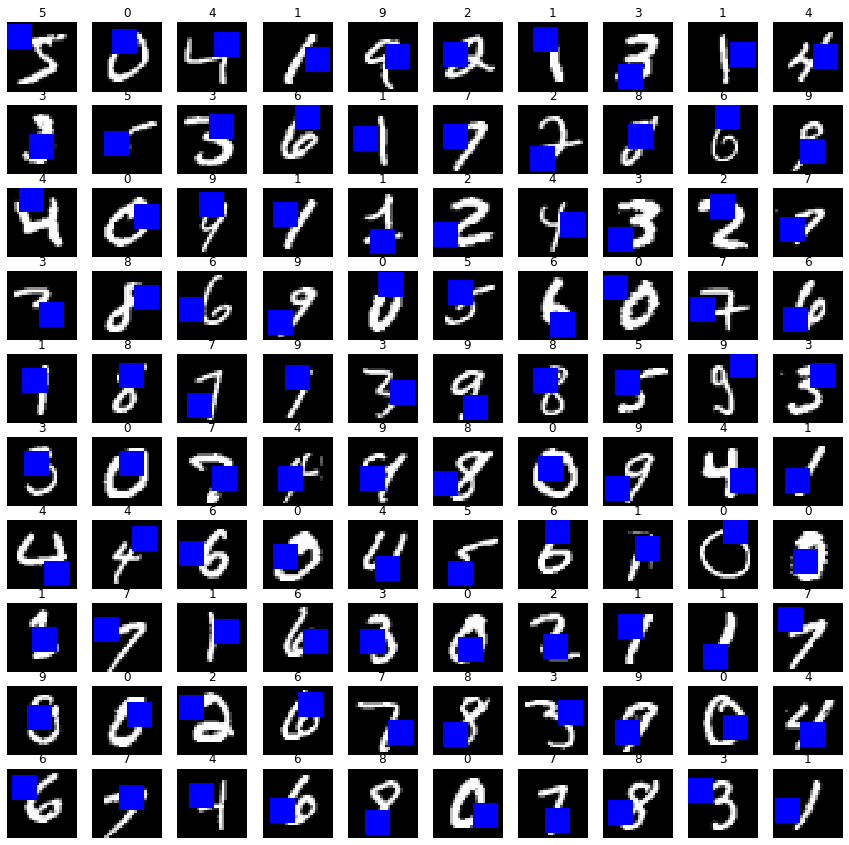

In [10]:
ds_train, ds_val = train_val_datasets(
    Path.home() / "uj/data/",
    mask_configs=[
        RandomRectangleMaskConfig(mc.UNKNOWN_LOSS, 10, 10, 0,0),
#         RandomRectangleMaskConfig(mc.UNKNOWN_NO_LOSS, 10,10, 0,0)
    ],
    ds_type=MNIST
)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y}")
    vis_digit_mask(x, j,ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

In [11]:
batch_size=96
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [12]:
log_noms = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_noms"]

x_minus_means = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means"]

x_minus_means_2 = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means_2"]

log_dets = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_dets"]

log_2_pi = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_2_pi"]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# device = torch.device("cpu")
history = []
# inpainter = MNISTLinearInpainter(n_mixes=1, hidden_size=2048)
inpainter = MNISTConvolutionalInpainter(n_mixes=1, a_width=4)

# inpainter.extractor = deep_extractor

opt = optim.Adam(inpainter.parameters(), lr=4e-5, weight_decay=0)
n_epochs = 50
history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn = log_dets, 
    n_epochs=n_epochs,
    losses_to_log=dict(
        log_noms=log_dets,
        x_minus_means_2=x_minus_means_2,
        x_minus_means=x_minus_means,
        log_dets=log_dets,
        log_2_pi=log_2_pi,
        nll=nll_masked_batch_loss,
    ),
    device=device,
    history_start=history,
#     tqdm_loader=True
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 50/50 [1:37:20<00:00, 116.81s/it]


In [14]:
# history = history_tmp

In [15]:
history[0]["losses"]

{'log_noms': {'train': -1111.1893, 'val': -1111.5276},
 'x_minus_means_2': {'train': 45.65017, 'val': 44.414856},
 'x_minus_means': {'train': 52.96698, 'val': 51.312695},
 'log_dets': {'train': -1111.1893, 'val': -1111.5276},
 'log_2_pi': {'train': 91.89385, 'val': 91.89385},
 'nll': {'train': 97671630000.0, 'val': 106911090000.0},
 'objective': {'train': -1111.1893, 'val': -1111.5276}}

In [16]:

with (experiment_path / "history_last_epoch.pkl").open("wb") as f:
    history_tmp = history
    pickle.dump(history[-1], f)

In [17]:
with (experiment_path / "inpainter.schema").open("w") as f:
    print(inpainter, file=f)
with (experiment_path / "opt.schema").open("w") as f:
    print(opt, file=f)

# torch.save(inpainter.state_dict, experiment_path / "inpainter.state")

In [18]:
history[-1]["losses"]["objective"]

{'train': -1135.8872, 'val': -1135.7319}

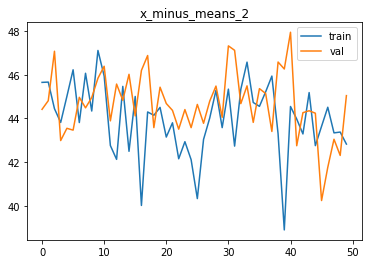

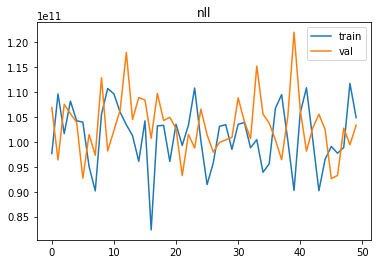

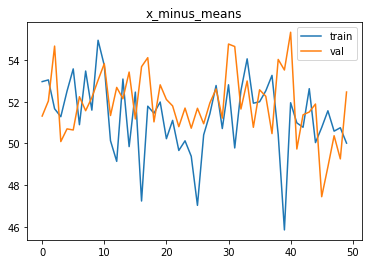

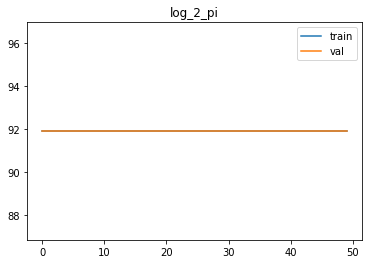

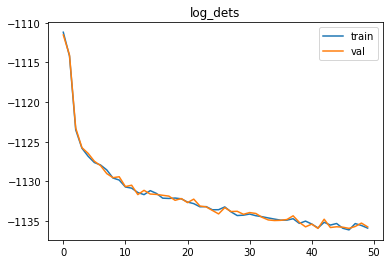

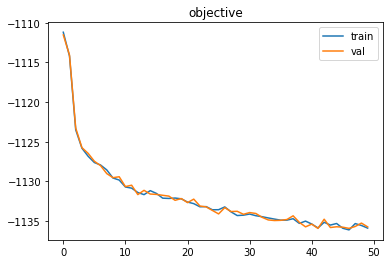

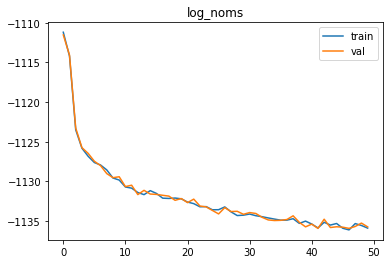

In [19]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    fig = plt.gcf()
    fig.savefig(experiment_path / f"history.{loss_name}.png")
    plt.show()

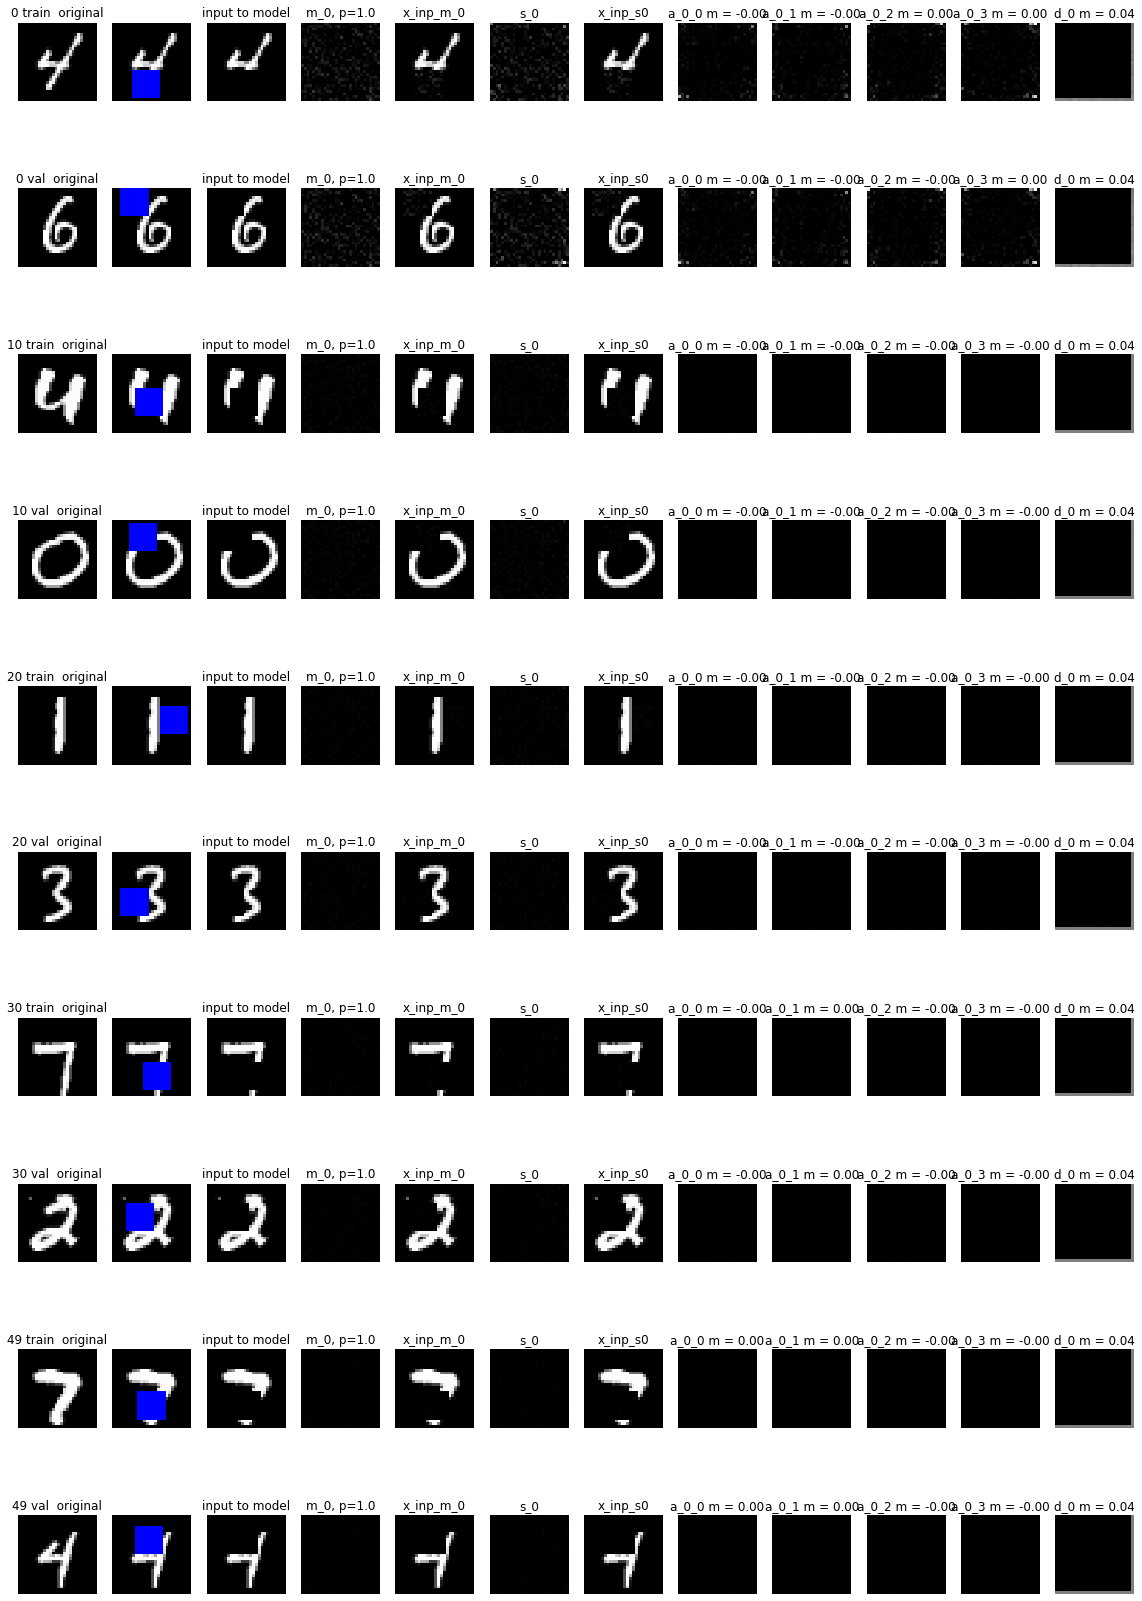

In [20]:
skip = 10

row_length = vis.row_length(*list(zip(*history[0]["sample_results"]["train"]))[0])
fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    row_length,
    figsize=(20, 30)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no

        vis.visualize_sample(
            x, j, p, m, a, d, y, 
            ax_row=axes[row_no], 
            title_prefixes={
                0: f"{e} {fold} ",
#                 1: f"y_m = {y_masked_pred}"
            },
            drawing_fn=vis_digit_mask
        )

epochs_fig = plt.gcf()
epochs_fig.savefig(experiment_path / "epochs_renders.png")

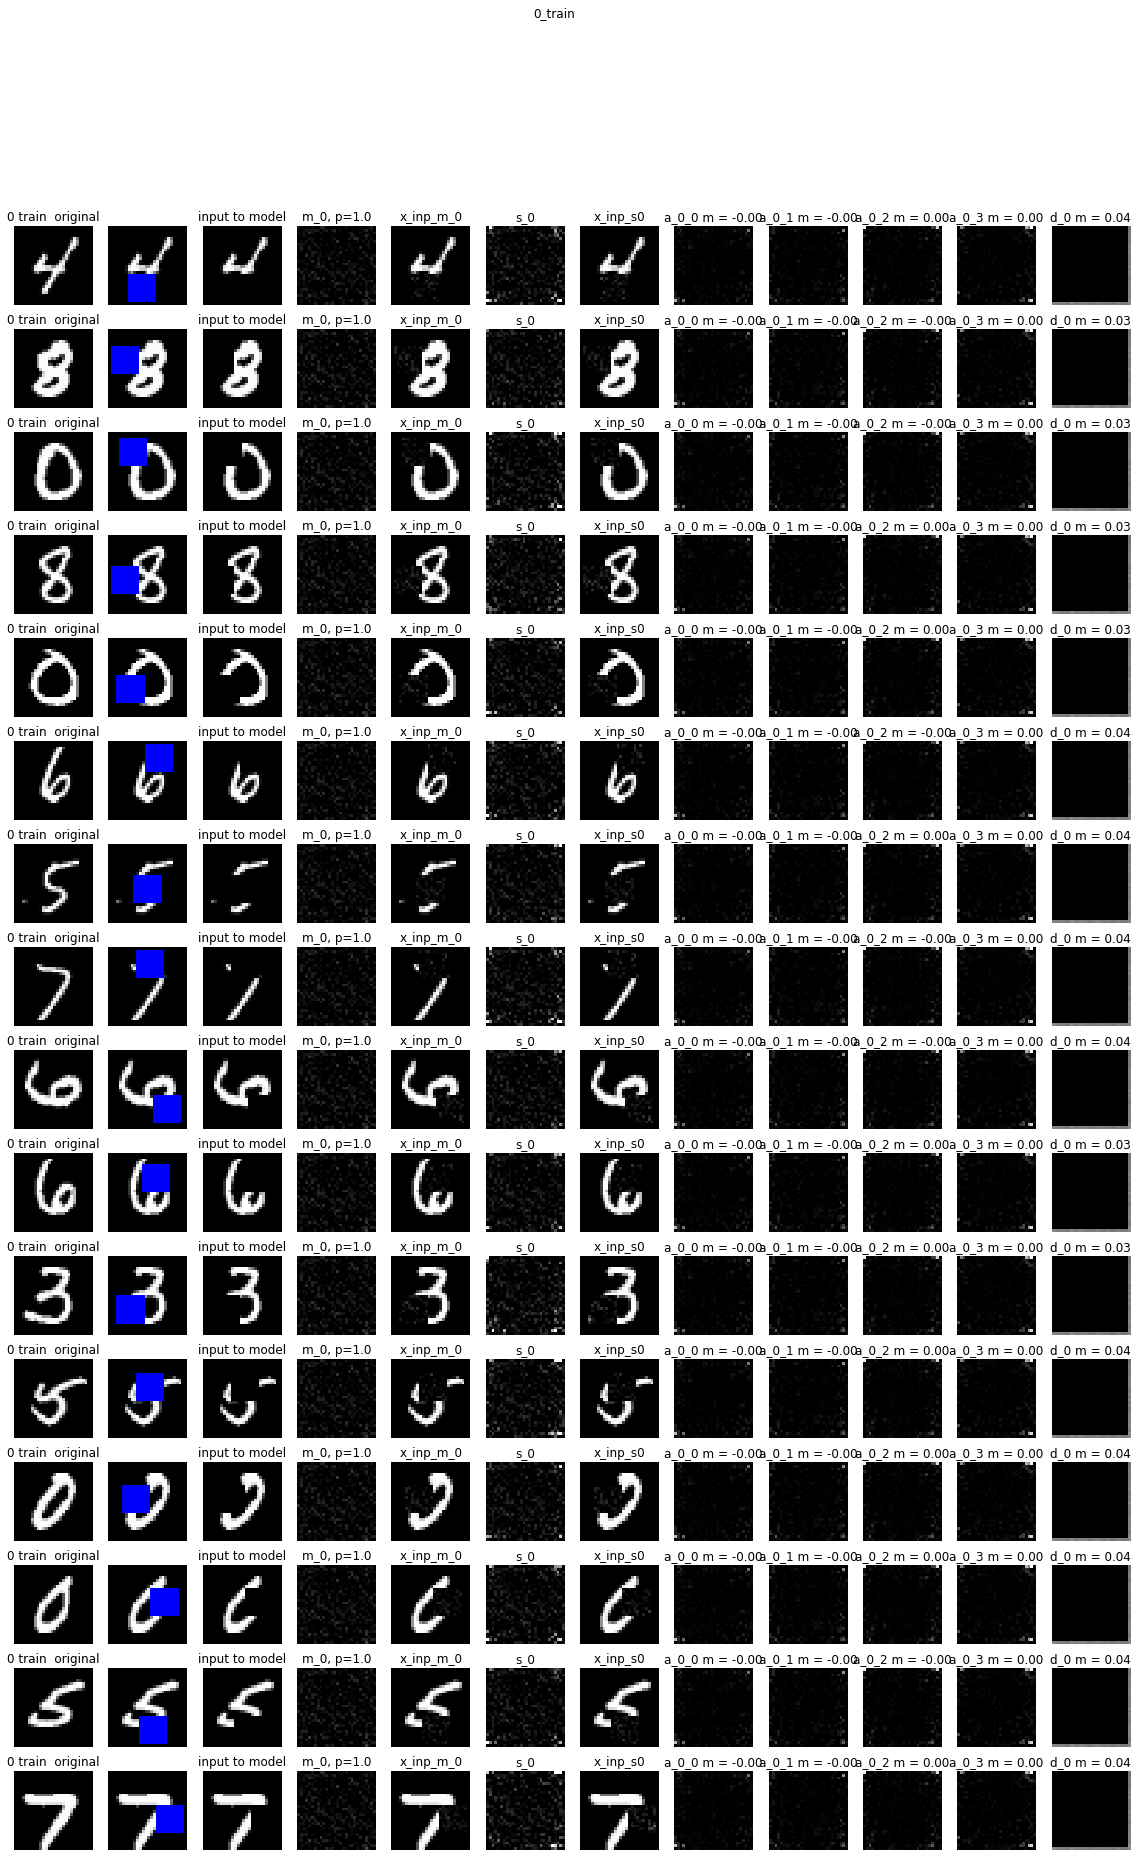

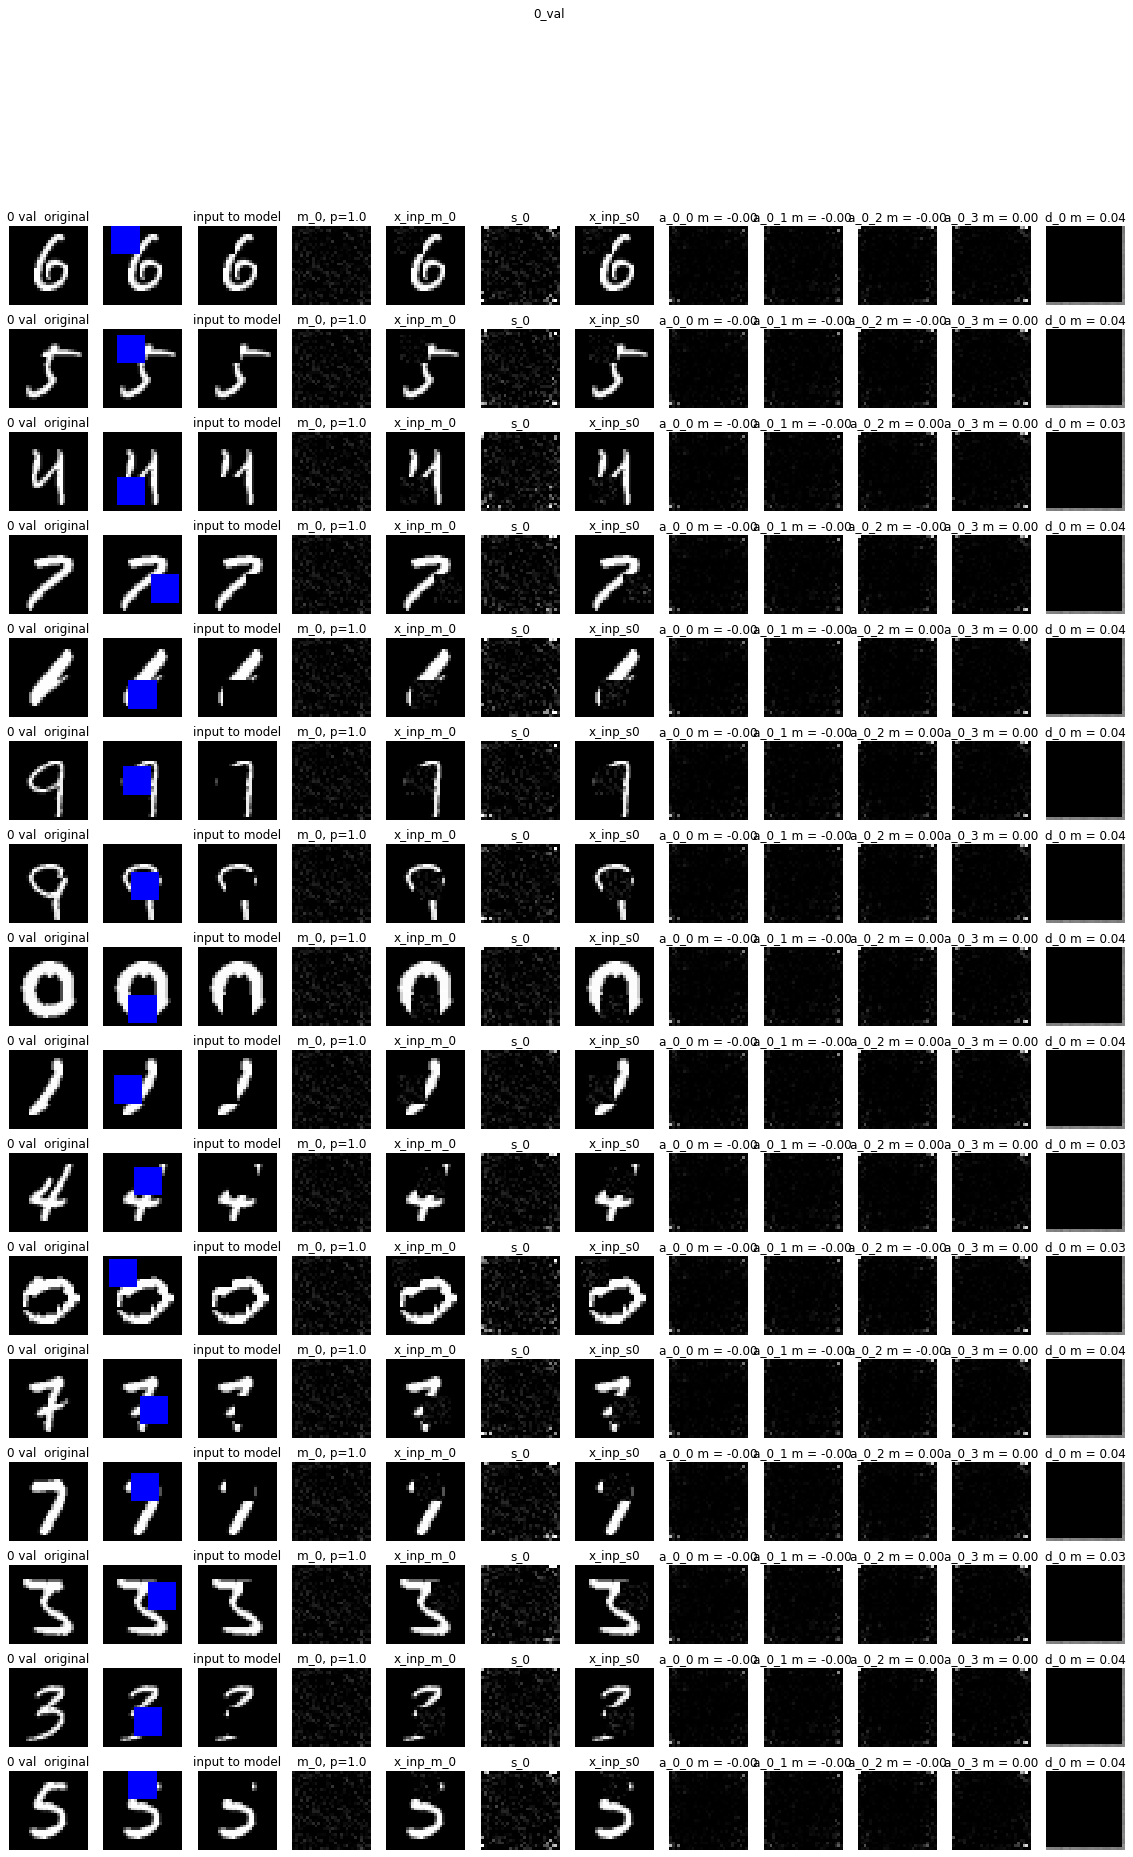

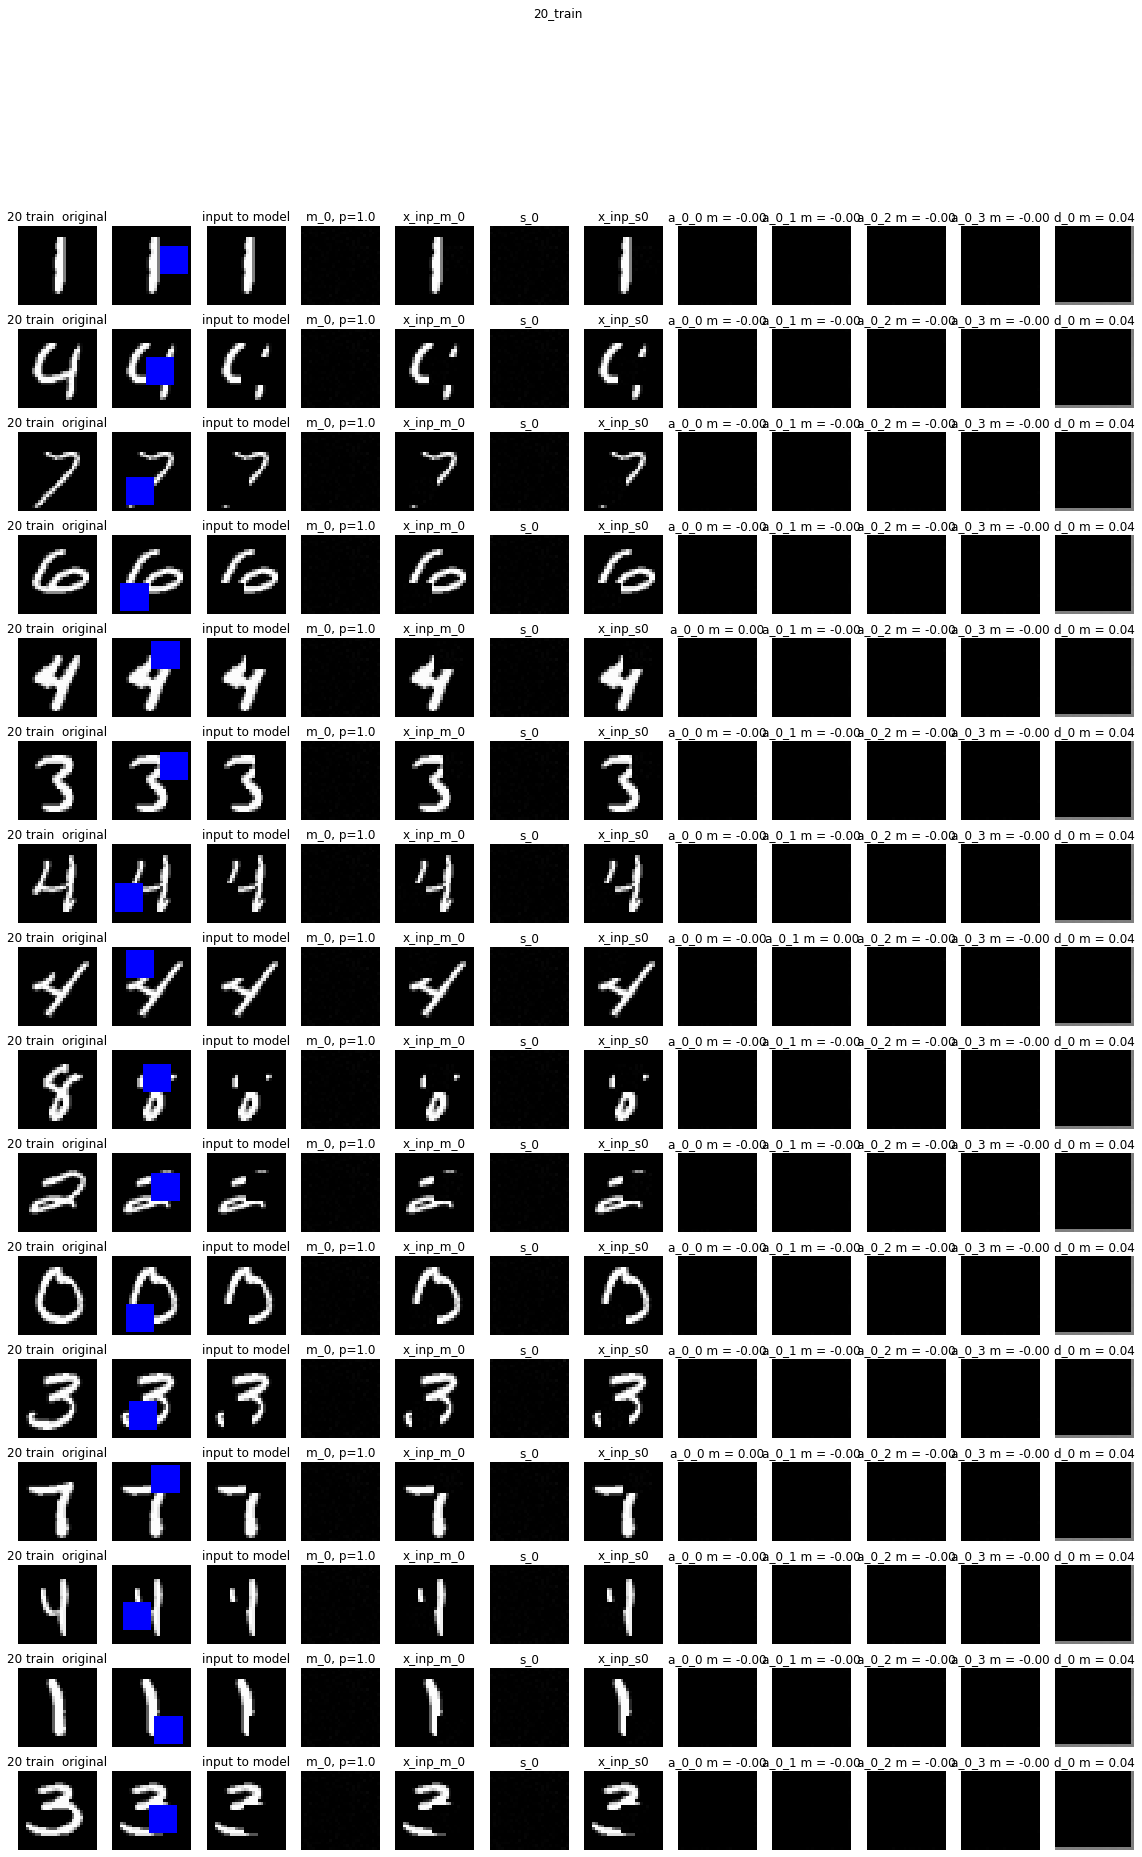

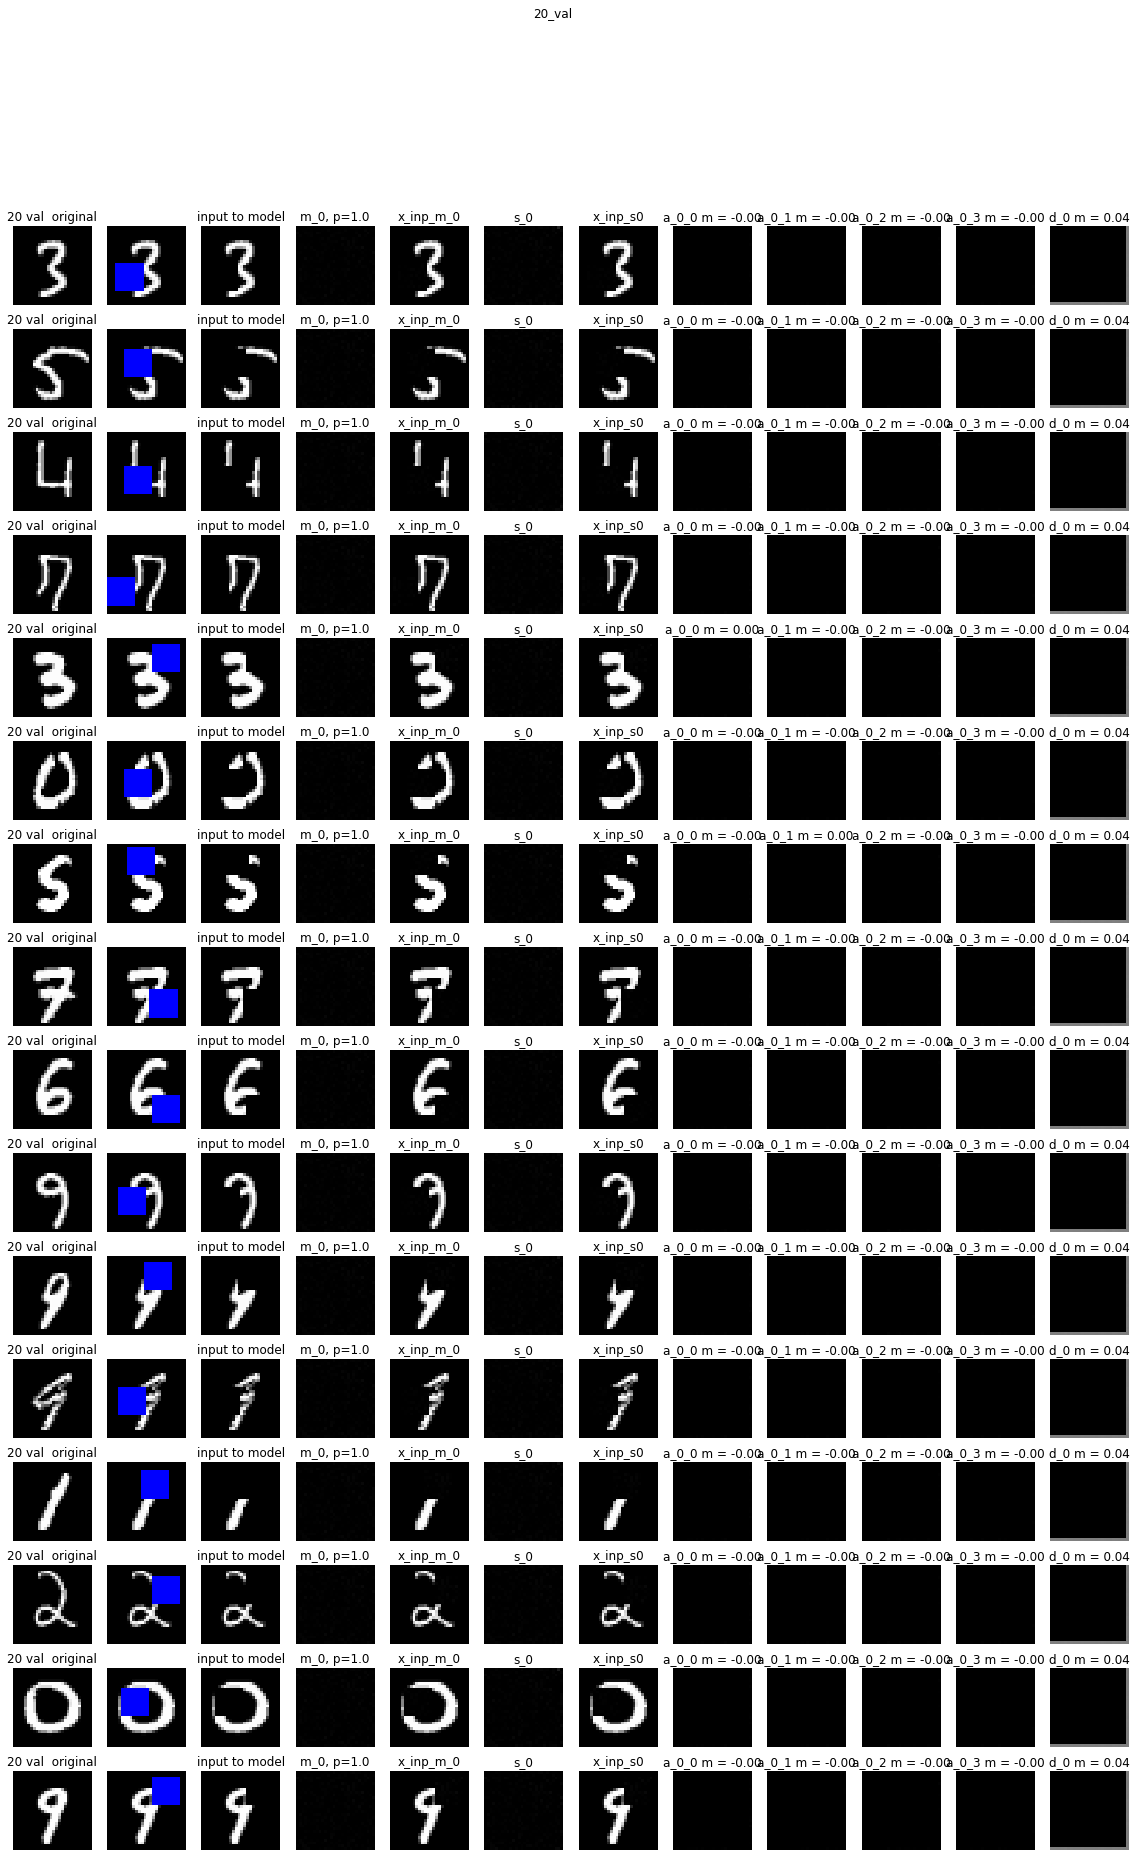

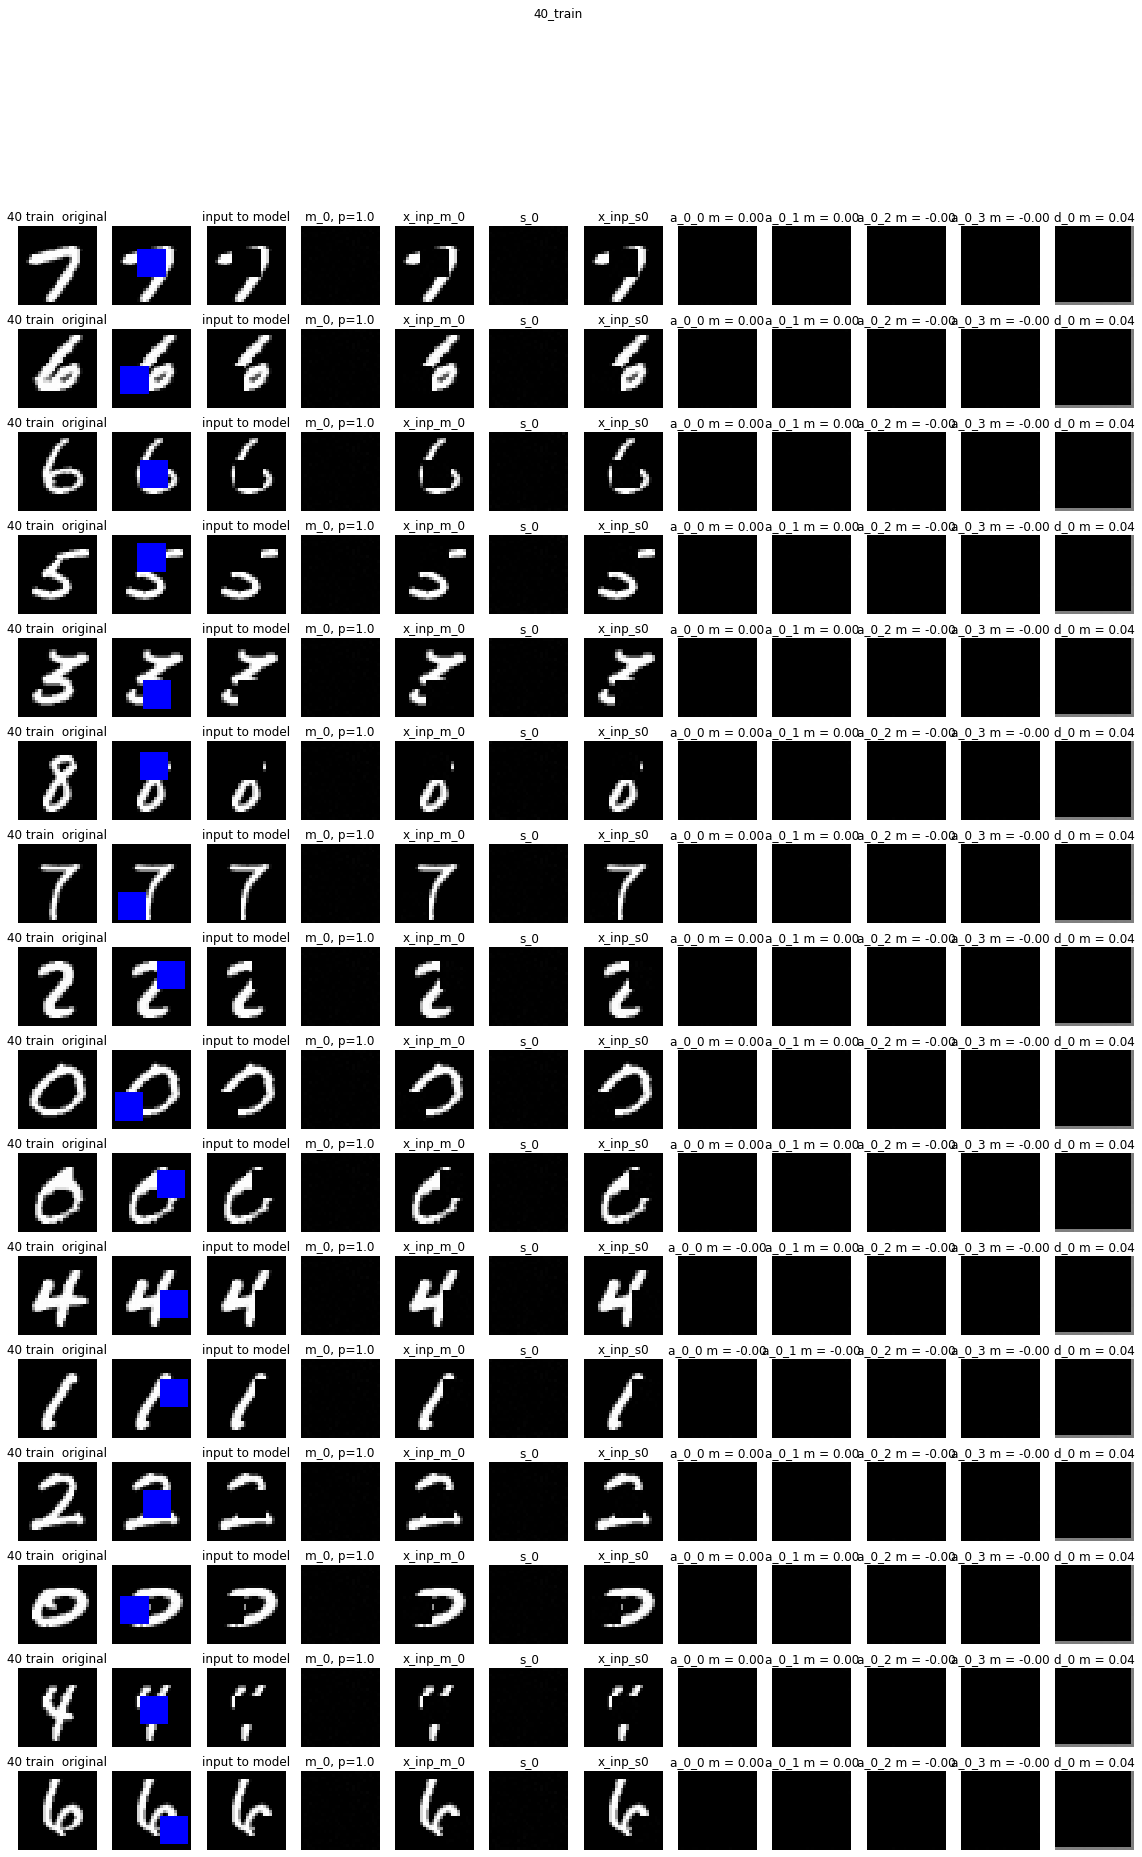

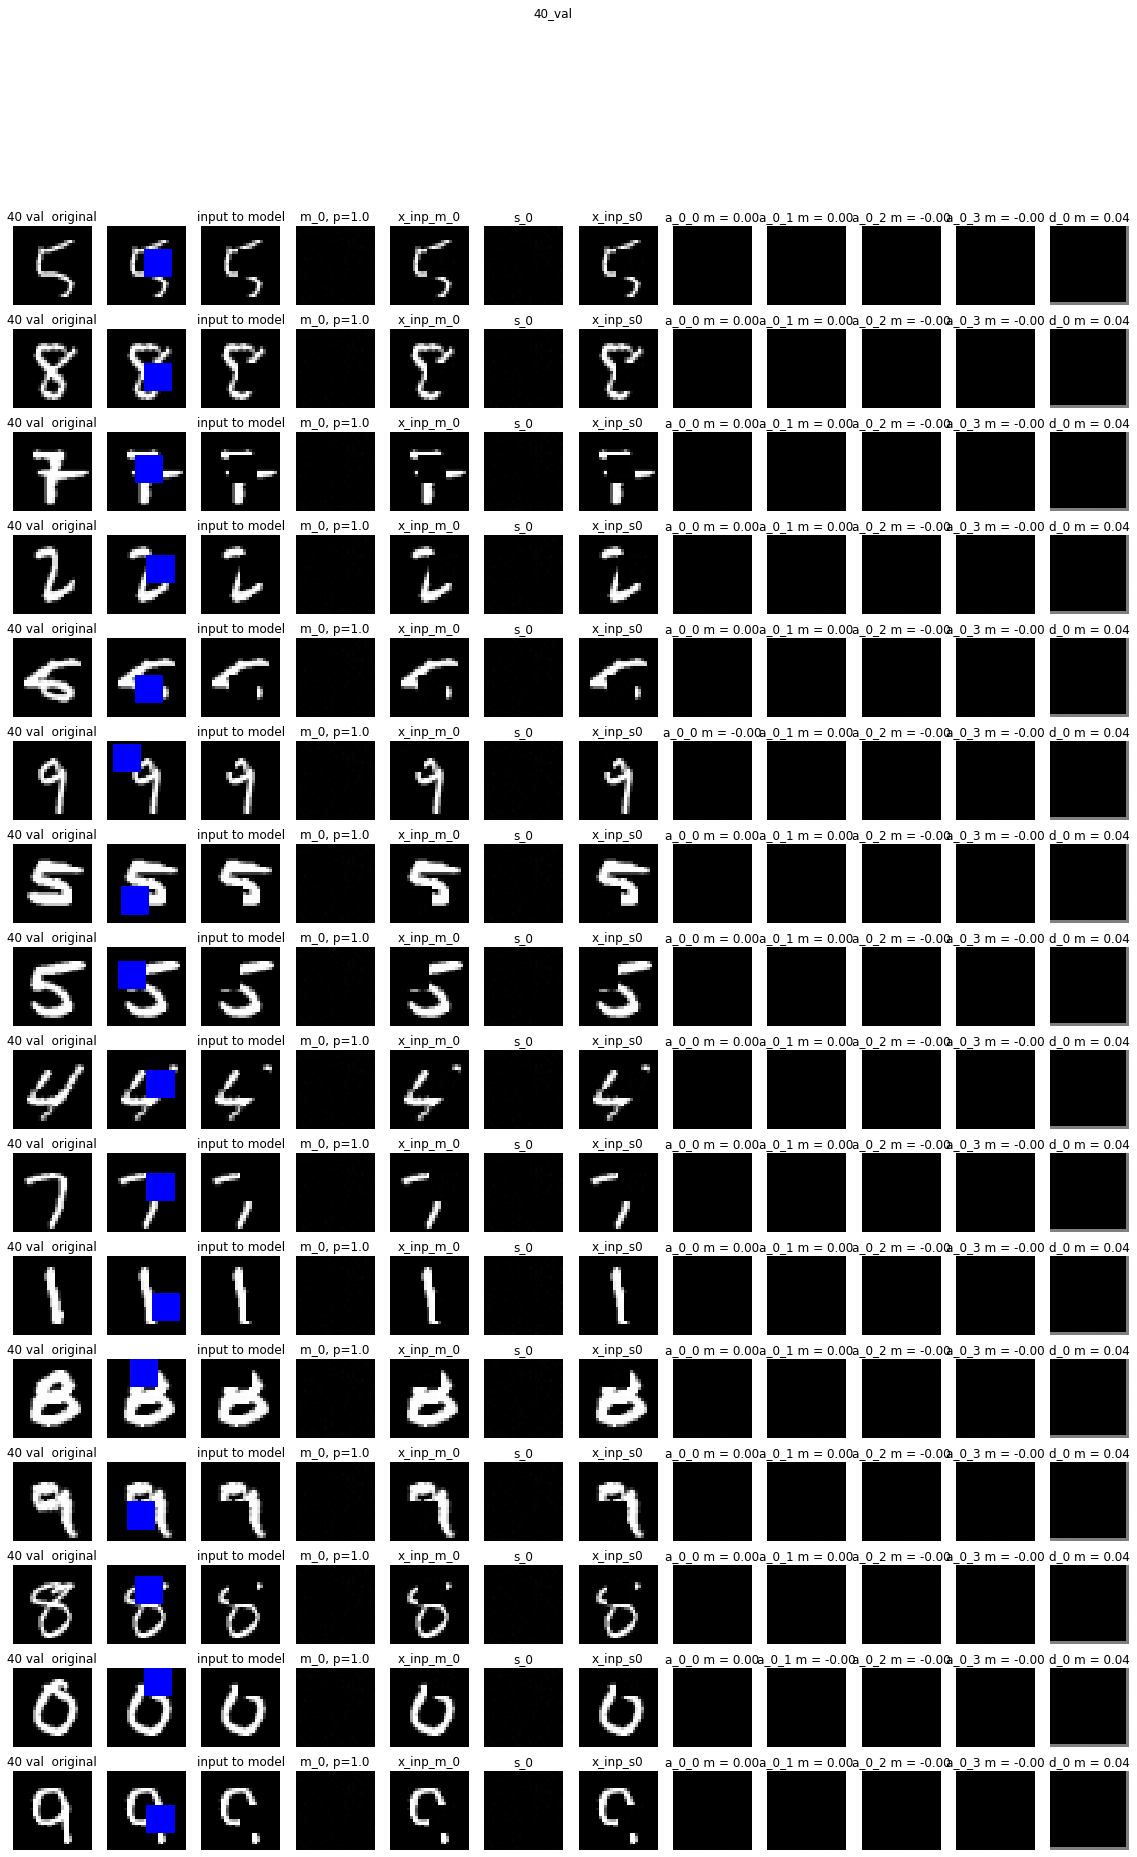

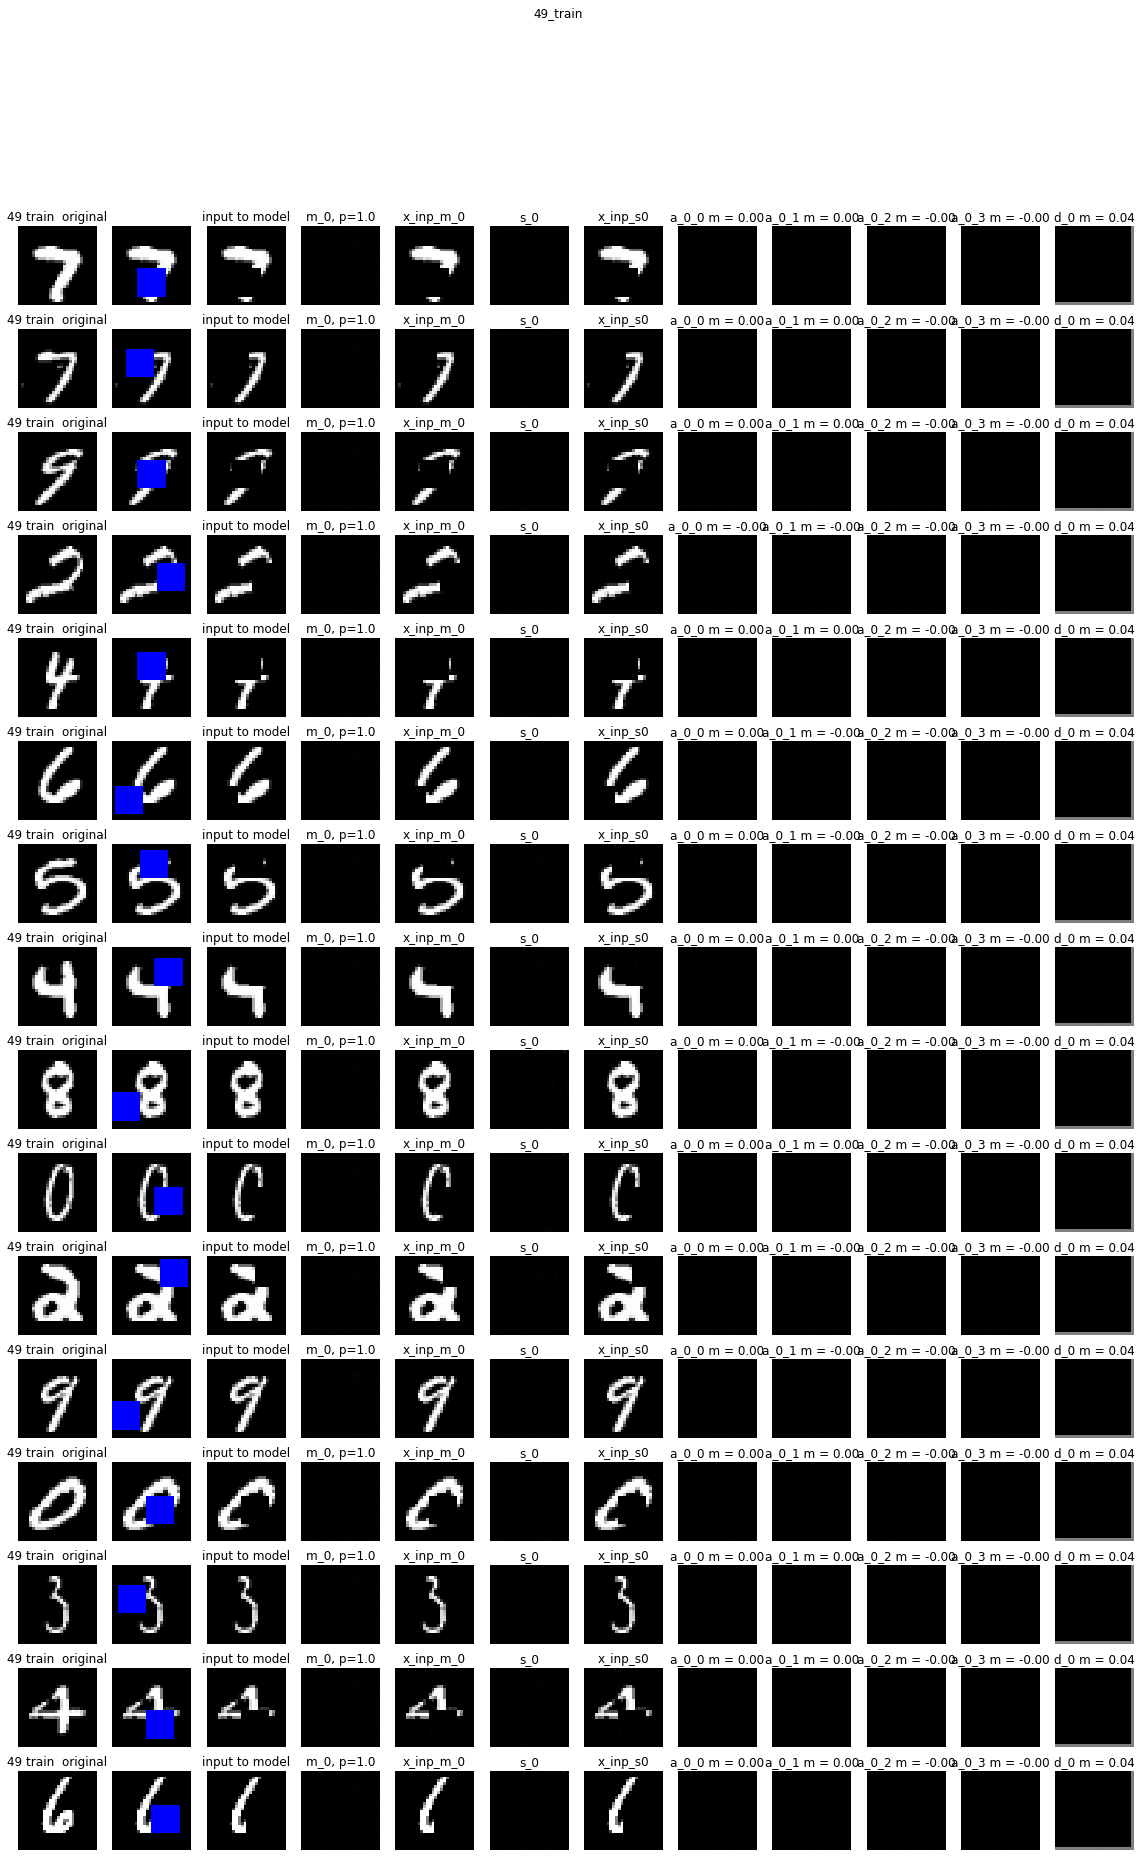

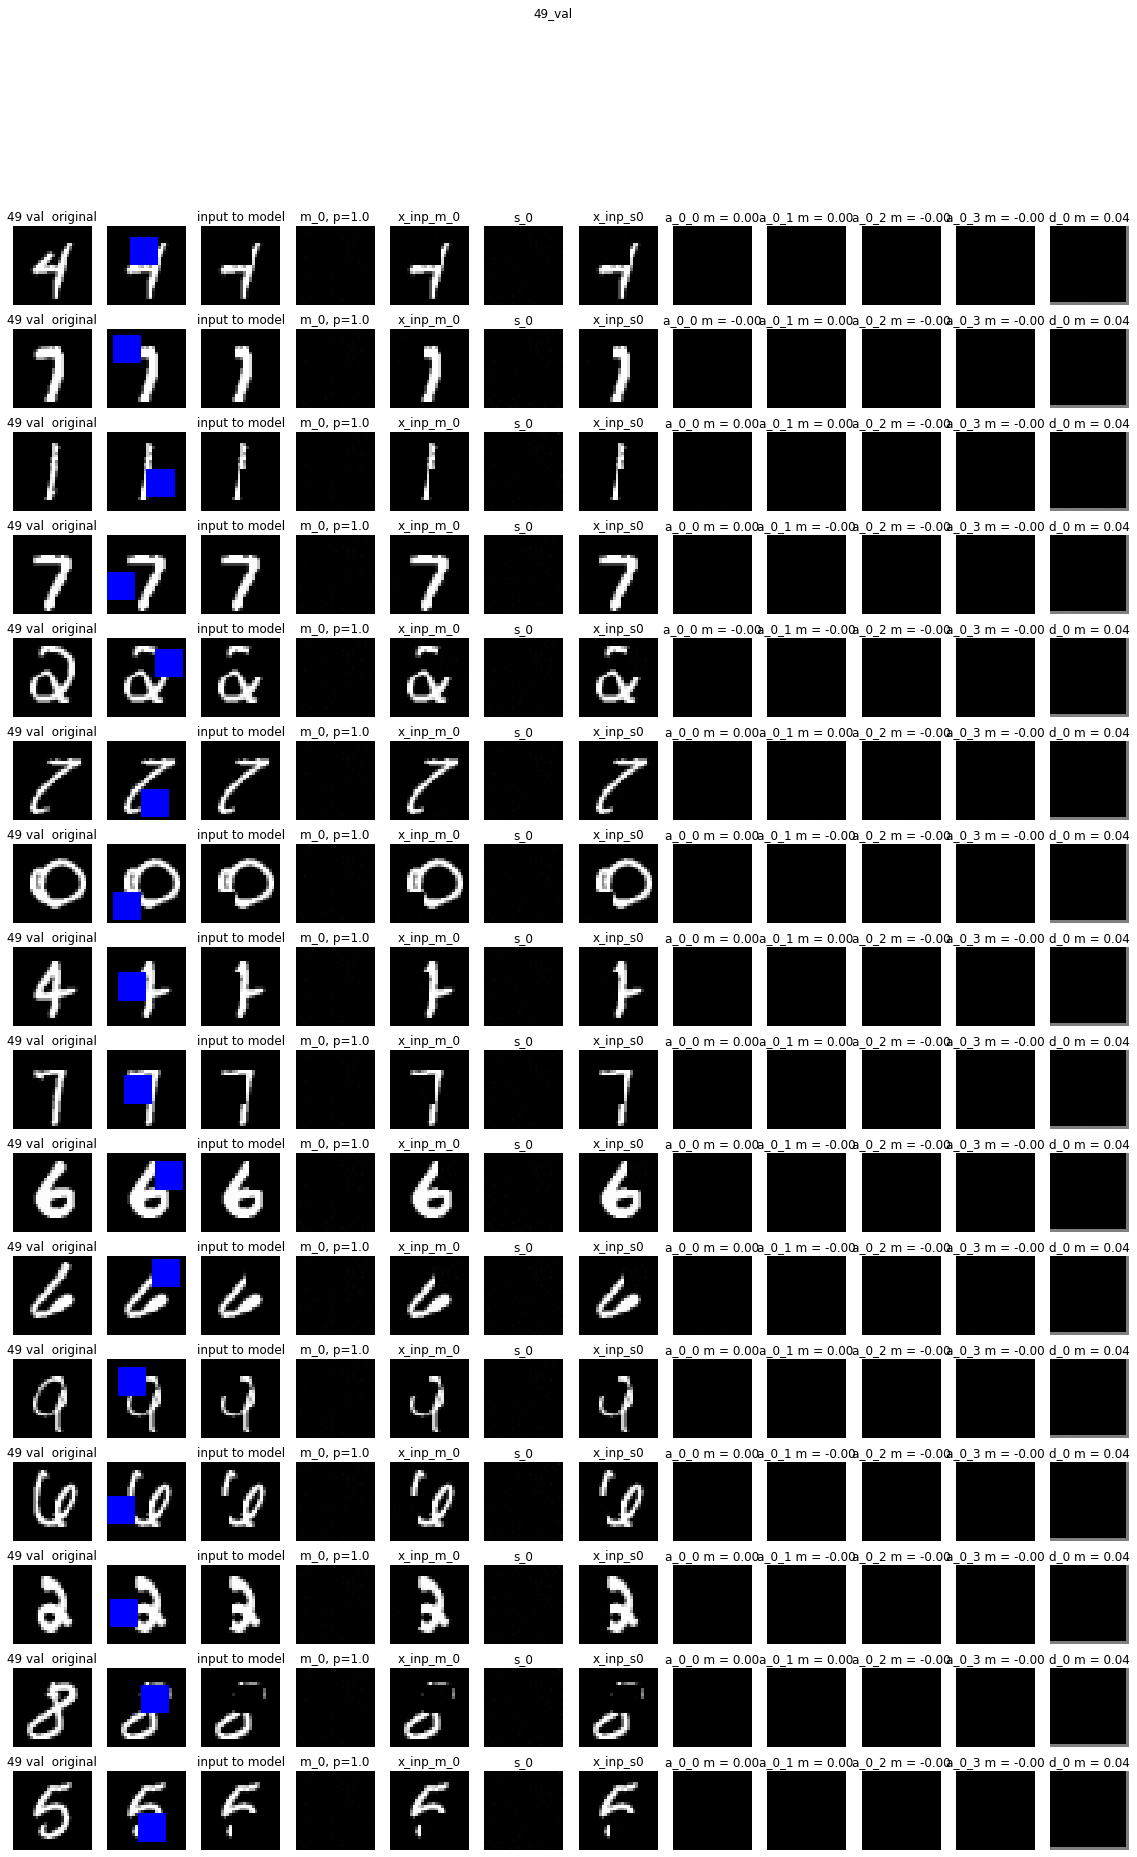

In [21]:
epochs_path = experiment_path / "epochs"
epochs_path.mkdir(exist_ok=True)
skip = 20
n_rows = 16

for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        
        row_length = vis.row_length(*list(zip(*h["sample_results"][fold]))[0])

        fig, axes = plt.subplots(
            n_rows, 
            row_length,
            figsize=(20, 30)
        )

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(*h["sample_results"][fold]))[:n_rows]):
            vis.visualize_sample(
                x, j, p, m, a, d, y, 
                ax_row=axes[row_no], 
                title_prefixes={
                    0: f"{e} {fold} ",
#                     1: f"y_m = {y_masked_pred}"
                },
                drawing_fn=vis_digit_mask

            )
        
        title = f"{e}_{fold}"
        plt.suptitle(title)
        plt.savefig(epochs_path / f"{title}.png")
#       

In [22]:
import pickle

with (experiment_path / "history_last_epoch.pkl").open("rb") as f:
    hist_last_epoch = pickle.load(f)

history = [hist_last_epoch]

In [23]:
import matplotlib.pyplot as plt

def plot_arrays_stats(
    arrays, ax=None, stat_fns = [np.min, np.max, np.mean], markers="."
):
    if ax is None:
        fig, ax = plt.subplots()
        
    if isinstance(markers, str):
        markers = [markers] * len(stat_fns)
    
    for fn, m in zip(stat_fns, markers):
        ax.scatter(
            range(len(arrays)),
            [
                fn(a) for a in arrays
            ],
            marker=m,
            label=fn.__name__
            
        )
    
    return ax

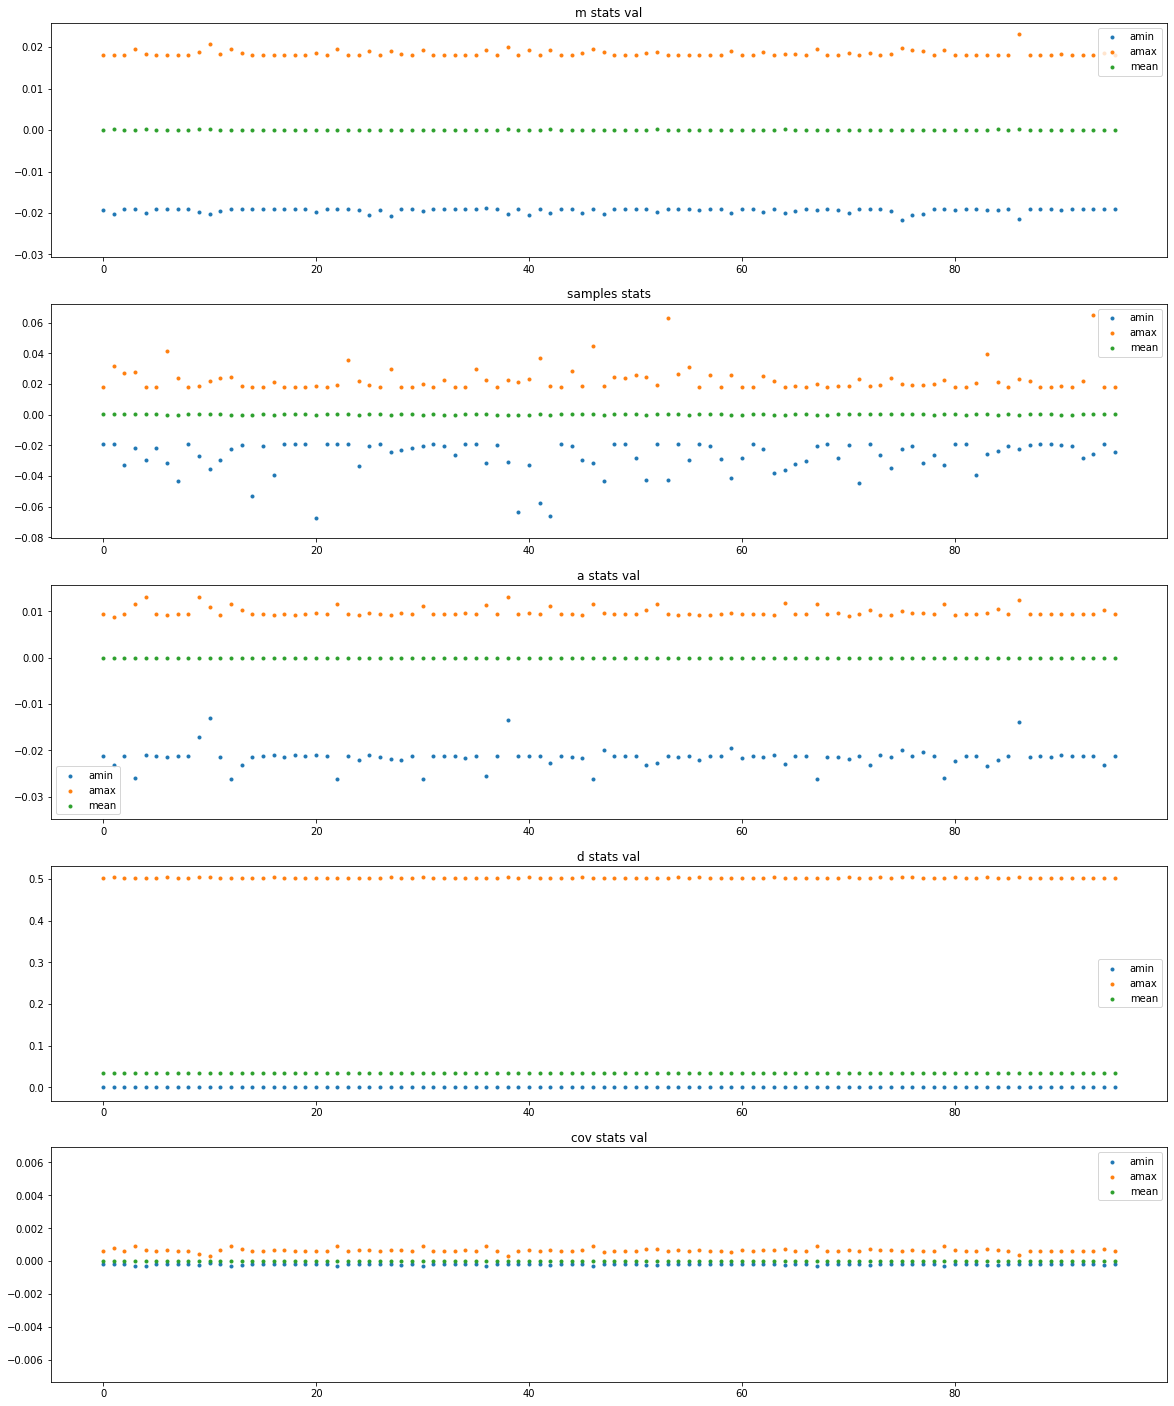

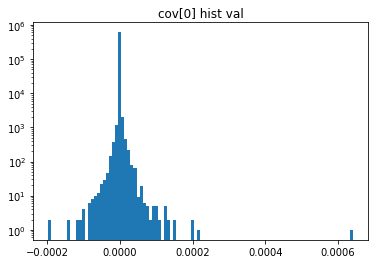

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


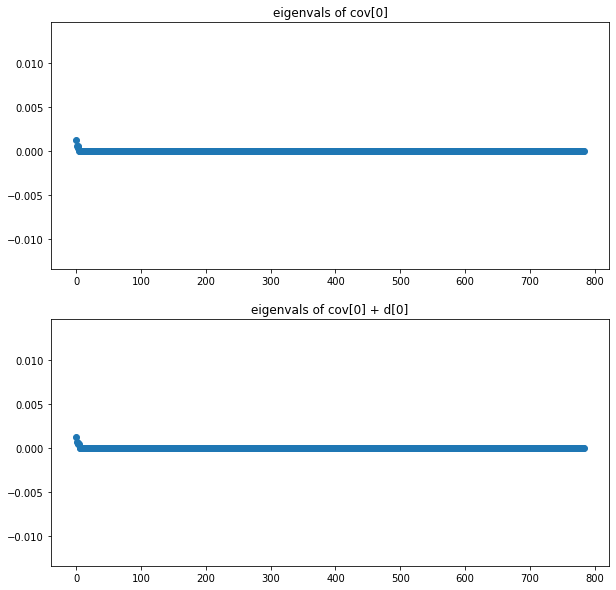

m analysis


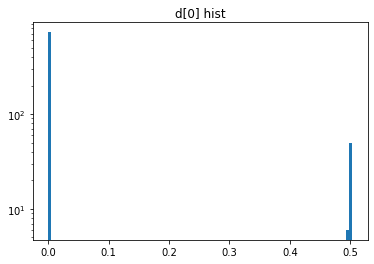

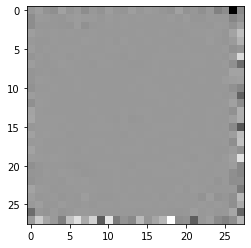

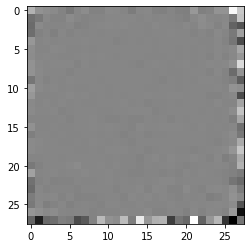

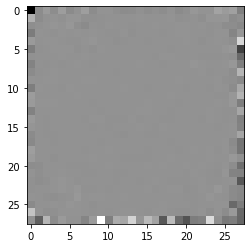

In [24]:
for fold in ["val"]:
    x, j, p, m, a, d, y = hist_last_epoch["sample_results"][fold]

    a_resh = a.reshape(a.shape[0] * a.shape[1], a.shape[2], a.shape[3])
    covs = a_resh.transpose(0, 2, 1) @ a_resh
    
    fig, ax = plt.subplots(figsize=(20, 25), nrows=5)
    
    ax[0].set_title(f"m stats {fold}")
    plot_arrays_stats(
        m, ax[0]
    )
        
    samples = [
        vis.gans_gmms_sample_no_d(x_, m_[0], a_[0], d_[0])
        for (x_, m_, a_, d_) in zip(x, m ,a, d)
    ]
    
    ax[1].set_title("samples stats")
    plot_arrays_stats(samples, ax[1])
    
    ax[2].set_title(f"a stats {fold}")
    plot_arrays_stats(
        a, ax[2]
    )
    
    ax[3].set_title(f"d stats {fold}")
    plot_arrays_stats(
        d, ax[3]
    )
    
    ax[4].set_title(f"cov stats {fold}")
    plot_arrays_stats(
        covs, ax[4]
    )
    [a.legend() for a in ax[:5]]
    fig.savefig(experiment_path / f"outputs_stats.png")
    plt.show()
    
    cov_resh = covs[0].reshape(-1)
    plt.hist(cov_resh, log=True, bins=100)
    plt.title(f"cov[0] hist {fold}")
    plt.show()
    
    cov = covs[0]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
    eigs = np.linalg.eigvals(cov)
    ax[0].scatter(range(len(eigs)), eigs)
    ax[0].set_title("eigenvals of cov[0]")

    cov_d = cov + np.diag(d[0])
    eigs_d = np.linalg.eigvals(cov_d)
    ax[1].scatter(range(len(eigs_d)), eigs_d)
    ax[1].set_title("eigenvals of cov[0] + d[0]")
    fig.savefig(experiment_path / "eigenvals.png")
    plt.show()

    # wygląda na to, że mamy ~3 duże wartosci własne
    
    print("m analysis")
    
    
    plt.hist(d[0].reshape(-1), bins=100, log=True)
    plt.title("d[0] hist")
    plt.show()
    
    for i in range(3):
        plt.imshow(a_resh[0, i].reshape(28,28), cmap="gray")
        plt.show()
    
    
    
    

In [25]:
# next up
# * różne aktywacje wyjścia macierzy A (sigmoid? różne zakresy?)
# * wyplotować wielkość wartości własne A, D na przestrzeni treningu
# spróbować trenowania na niepełnych danych